In [1]:
import os
import torch
from sentence_transformers import SentenceTransformer, util
from tqdm import tqdm

# Path to the directory containing abstract files
data_dir = "./20k_abstracts_numbers_with_@/"
# Specify the path to the training data file
file_path = "./20k_abstracts_numbers_with_@/train.txt"

# Function to parse the data from the file
def parse_data(file_path):
    with open(file_path, 'r') as file:
        data = file.read()  # Read the entire content of the file

    entries = data.split('###')  # Split data into individual entries
    papers = []  # List to store the parsed papers

    for entry in entries:
        if entry.strip():
            lines = entry.strip().split('\n')
            abstract_id = lines[0].strip()  # First line is the abstract ID
            title = ""
            abstract = []

            for line in lines[1:]:  # Skip the first line (abstract ID)
                parts = line.split('\t')
                if len(parts) > 1:
                    if line.startswith("OBJECTIVE"):
                        title = parts[1].strip()  # Assuming the title follows OBJECTIVE
                    else:
                        abstract.append(parts[1].strip())  # Collect abstract lines

            if not title:  # Skip if no title is found
                continue

            abstract_text = ' '.join(abstract)  # Join abstract lines into a single string
            research_paper_link = f'https://www.ncbi.nlm.nih.gov/pubmed/{abstract_id}'

            papers.append({
                'abstract_id': abstract_id,
                'title': title,
                'abstract': abstract_text,
                'research-paper-link': research_paper_link
            })

    return papers


# Parse the data from the file
papers = parse_data(file_path)

# Load models
model_specter = SentenceTransformer('allenai-specter')
model_sbert = SentenceTransformer('all-MiniLM-L6-v2')  # SBERT model for sentence-level embeddings

      

C:\Users\Nony\anaconda3\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
C:\Users\Nony\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [2]:
# Function to compute and save embeddings for each model
def compute_query_embedding(query, model):
    return model.encode(query, convert_to_tensor=True)
def compute_embeddings(papers, model, filename, batch_size=128):
    texts = [paper['title'] + ' ' + paper['abstract'] for paper in papers]
    all_embeddings = []

    # Using tqdm for progress bar
    for i in tqdm(range(0, len(texts), batch_size), desc=f"Processing {model.__class__.__name__} Batches"):
        batch_texts = texts[i:i + batch_size]
        batch_embeddings = model.encode(batch_texts, convert_to_tensor=True)
        all_embeddings.append(batch_embeddings)

    embeddings = torch.cat(all_embeddings, dim=0)
    torch.save(embeddings, filename)  # Save the embeddings
    return embeddings

# Paths to save the computed embeddings
embeddings_file_specter = 'corpus_embeddings_specter.pt'
embeddings_file_sbert = 'corpus_embeddings_sbert.pt'

# Check if precomputed embeddings files exist, if not compute and save them
if os.path.exists(embeddings_file_specter):
    corpus_embeddings_specter = torch.load(embeddings_file_specter)
    print("Loaded precomputed SPECTER embeddings.")
else:
    corpus_embeddings_specter = compute_embeddings(papers, model_specter, embeddings_file_specter)
    print("Computed and saved SPECTER embeddings.")

if os.path.exists(embeddings_file_sbert):
    corpus_embeddings_sbert = torch.load(embeddings_file_sbert)
    print("Loaded precomputed SBERT embeddings.")
else:
    corpus_embeddings_sbert = compute_embeddings(papers, model_sbert, embeddings_file_sbert)
    print("Computed and saved SBERT embeddings.")

# Function to normalize scores
def normalize_scores(results):
    scores = [hit['score'] for hit in results]
    min_score = min(scores)
    max_score = max(scores)

    # If all scores are the same, return them unchanged to avoid division by zero
    if max_score == min_score:
        return results

    # Normalize each score between 0 and 1
    for hit in results:
        hit['score'] = (hit['score'] - min_score) / (max_score - min_score)
    return results

Loaded precomputed SPECTER embeddings.
Loaded precomputed SBERT embeddings.


C:\Users\Nony\AppData\Local\Temp\ipykernel_35340\1358427461.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  corpus_embeddings_specter = torch.load(embeddings_file_spect

In [3]:

def hybrid_search(query, papers, corpus_embeddings_specter, corpus_embeddings_sbert):
    try:
        # Compute embeddings for the query using both models
        query_embedding_specter = compute_query_embedding(query, model_specter)
        query_embedding_sbert = compute_query_embedding(query, model_sbert)
        
        # Perform semantic search using SPECTER embeddings
        search_results_specter = util.semantic_search(query_embedding_specter, corpus_embeddings_specter, top_k=10)[0]
        search_results_specter = normalize_scores(search_results_specter)

        # Perform semantic search using SBERT embeddings
        search_results_sbert = util.semantic_search(query_embedding_sbert, corpus_embeddings_sbert, top_k=10)[0]
        search_results_sbert = normalize_scores(search_results_sbert)

        # Debugging prints
        print(f"Number of SPECTER results: {len(search_results_specter)}")
        print(f"Number of SBERT results: {len(search_results_sbert)}")

        # Combine results
        combined_results = {}

        # Add SPECTER results
        for hit in search_results_specter:
            paper = papers[hit['corpus_id']]
            print(f"Adding SPECTER Paper: {paper['title']} with score {hit['score']}")
            combined_results[hit['corpus_id']] = {
                'title': paper['title'],
                'abstract': paper['abstract'],
                'link': paper['research-paper-link'],
                'score': hit['score'],
                'model': 'SPECTER'
            }

        # Add SBERT results
        for hit in search_results_sbert:
            paper = papers[hit['corpus_id']]
            print(f"Evaluating SBERT Paper: {paper['title']} with score {hit['score']}")
            if hit['corpus_id'] not in combined_results:
                combined_results[hit['corpus_id']] = {
                    'title': paper['title'],
                    'abstract': paper['abstract'],
                    'link': paper['research-paper-link'],
                    'score': hit['score'],
                    'model': 'SBERT'
                }
                print(f"Added SBERT Paper: {paper['title']}")
            else:
                # If the result is already in combined, take the higher score
                existing_score = combined_results[hit['corpus_id']]['score']
                combined_results[hit['corpus_id']]['score'] = max(existing_score, hit['score'])
                # Update the model to Hybrid if SBERT score is higher
                if hit['score'] > existing_score:
                    combined_results[hit['corpus_id']]['model'] = 'Hybrid'
                    print(f"Updated Paper to Hybrid: {paper['title']} with score {hit['score']}")

        # Sort combined results by score
        sorted_results = sorted(combined_results.values(), key=lambda x: x['score'], reverse=True)

        # Debugging print for combined results
        print(f"Number of unique combined results: {len(sorted_results)}")

        return sorted_results, search_results_specter, search_results_sbert  # Return all results

    except Exception as e:
        print(f"An error occurred in hybrid_search: {e}")
        return [], [], []  # Return empty lists in case of error


# Function to format and display recommended papers
def format_recommended_papers(hybrid_results, search_results_specter, search_results_sbert, papers):
    try:
        # Display SPECTER Results
        print("\n--- SPECTER Recommendations ---\n")
        for i, hit in enumerate(search_results_specter):
            paper = papers[hit['corpus_id']]
            print(f"Recommended Paper {i + 1}:")
            print(f"Title: {paper['title']}")
            print(f"Abstract: {paper['abstract']}")
            print(f"Research Paper Link: {paper['research-paper-link']}")
            print(f"Score: {hit['score']:.4f}")
            print("Recommended by: **SPECTER** Model")
            print("\n" + "-" * 80 + "\n")

        # Display SBERT Results
        print("\n--- SBERT Recommendations ---\n")
        for i, hit in enumerate(search_results_sbert):
            paper = papers[hit['corpus_id']]
            print(f"Recommended Paper {i + 1}:")
            print(f"Title: {paper['title']}")
            print(f"Abstract: {paper['abstract']}")
            print(f"Research Paper Link: {paper['research-paper-link']}")
            print(f"Score: {hit['score']:.4f}")
            print("Recommended by: **SBERT** Model")
            print("\n" + "-" * 80 + "\n")

        # Display Hybrid Results
        print("\n--- Hybrid Recommendations ---\n")
        for i, paper in enumerate(hybrid_results):
            print(f"Recommended Paper {i + 1}:")
            print(f"Title: {paper['title']}")
            print(f"Abstract: {paper['abstract']}")
            print(f"Research Paper Link: {paper['link']}")
            print(f"Score: {paper['score']:.4f}")
            
            # Show whether recommended by SBERT, SPECTER, or both
            if paper['model'] == "SPECTER":
                print("Recommended by: **SPECTER** Model")
            elif paper['model'] == "SBERT":
                print("Recommended by: **SBERT** Model")
            else:
                print("Recommended by: **Hybrid** Model (best of SBERT and SPECTER)")

            print("\n" + "-" * 80 + "\n")

    except Exception as e:
        print(f"An error occurred in format_recommended_papers: {e}")





# Example query
query = "arthritis"

# Perform the search
all_results, search_results_specter, search_results_sbert = hybrid_search(query, papers, corpus_embeddings_specter, corpus_embeddings_sbert)

# Display the recommendations
format_recommended_papers(all_results, search_results_specter, search_results_sbert, papers)





Number of SPECTER results: 10
Number of SBERT results: 10
Adding SPECTER Paper: To develop and validate composite disease activity scores , based on widely available clinical measures , that would demonstrate improved correlation with detection of synovitis on magnetic resonance imaging ( MRI ) and radiographic progression , in comparison with conventional measures , in patients with rheumatoid arthritis ( RA ) . with score 1.0
Adding SPECTER Paper: Exploratory analyses were conducted to further characterize these findings . with score 0.5808397483278949
Adding SPECTER Paper: To determine whether gene expression profiles identified in peripheral whole blood samples could be used to determine therapeutic outcome in a cohort of children with newly diagnosed polyarticular juvenile idiopathic arthritis ( JIA ) . with score 0.5185058320863906
Adding SPECTER Paper: Pain flare occurrence and experience were measured over @ days . with score 0.443490958913988
Adding SPECTER Paper: Here , we ap

In [4]:
def format_top_hybrid_papers(hybrid_results, top_k=10):
    print("\n--- Top Hybrid Recommendations ---\n")
    
    # Get the top K results
    top_results = hybrid_results[:top_k]

    for i, paper in enumerate(top_results):
        print(f"Recommended Paper {i + 1}:")
        print(f"Title: {paper['title']}")
        print(f"Abstract: {paper['abstract']}")
        print(f"Research Paper Link: {paper['link']}")
        print(f"Score: {paper['score']:.4f}")
        
        # Show whether recommended by SBERT, SPECTER, or both
        if paper['model'] == "SPECTER":
            print("Recommended by: **SPECTER** Model")
        elif paper['model'] == "SBERT":
            print("Recommended by: **SBERT** Model")
        else:
            print("Recommended by: **Hybrid** Model (best of SBERT and SPECTER)")

        print("\n" + "-" * 80 + "\n")



# Display the top 7 hybrid recommendations
format_top_hybrid_papers(all_results, top_k=10)


--- Top Hybrid Recommendations ---

Recommended Paper 1:
Title: To develop and validate composite disease activity scores , based on widely available clinical measures , that would demonstrate improved correlation with detection of synovitis on magnetic resonance imaging ( MRI ) and radiographic progression , in comparison with conventional measures , in patients with rheumatoid arthritis ( RA ) .
Abstract: This study was conducted as a secondary study of @ RA clinical trials , GO-BEFORE ( development cohort ) and GO-FORWARD ( validation cohort ) . Generalized estimating equations were used to evaluate independent cross-sectional associations of component variables ( from all time points ) with concurrent MRI measures of synovitis and bone edema in the development cohort . Based on regression coefficients , modified versions of the Disease Activity Score in @ joints ( M-DAS@ ) , Simplified Disease Activity Index ( M-SDAI ) , and Clinical Disease Activity Index ( M-CDAI ) were generate

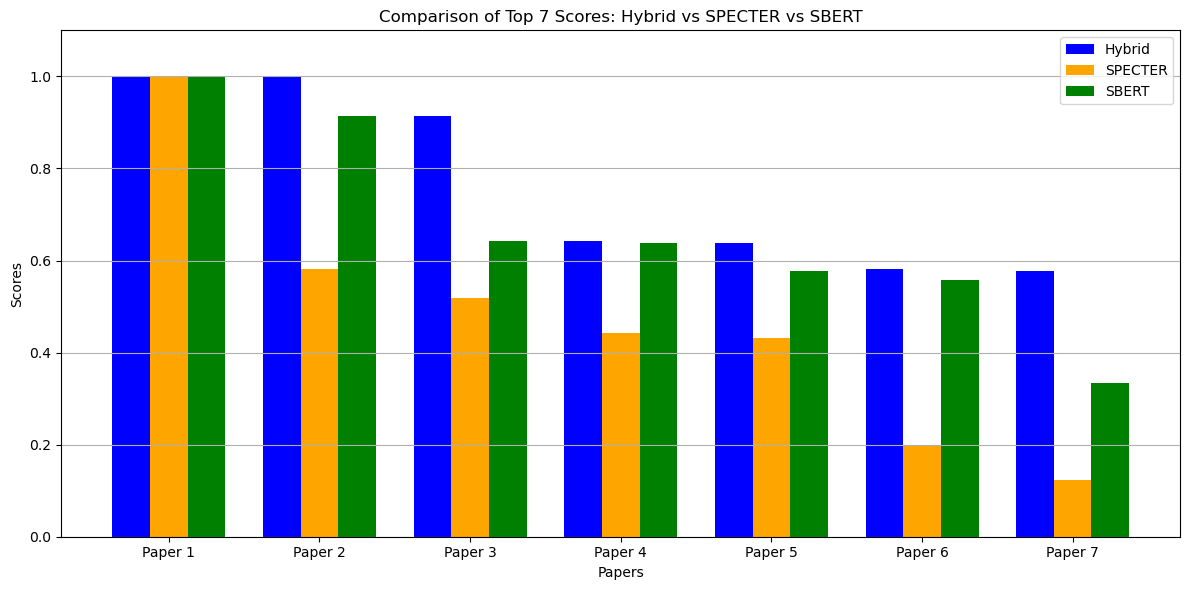

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_top_scores(hybrid_results, search_results_specter, search_results_sbert):
    # Get top 7 results for each model
    top_hybrid = hybrid_results[:7]  # Top 7 from hybrid
    top_specter = search_results_specter[:7]  # Top 7 from SPECTER
    top_sbert = search_results_sbert[:7]  # Top 7 from SBERT

    # Extract scores for the bar plot
    hybrid_scores = [paper['score'] for paper in top_hybrid]
    specter_scores = [hit['score'] for hit in top_specter]
    sbert_scores = [hit['score'] for hit in top_sbert]

    # Set up bar positions
    bar_width = 0.25
    indices = np.arange(len(hybrid_scores))

    # Create bar plots
    plt.figure(figsize=(12, 6))
    plt.bar(indices - bar_width, hybrid_scores, bar_width, label='Hybrid', color='blue')
    plt.bar(indices, specter_scores, bar_width, label='SPECTER', color='orange')
    plt.bar(indices + bar_width, sbert_scores, bar_width, label='SBERT', color='green')

    # Labeling the plot
    plt.xlabel('Papers')
    plt.ylabel('Scores')
    plt.title('Comparison of Top 7 Scores: Hybrid vs SPECTER vs SBERT')
    plt.xticks(indices, [f'Paper {i+1}' for i in range(7)])  # X-axis labels
    plt.ylim(0, max(max(hybrid_scores), max(specter_scores), max(sbert_scores)) + 0.1)  # Adjusting Y-axis
    plt.legend()
    plt.grid(axis='y')  # Adding grid for better readability
    plt.tight_layout()  # Adjust layout to avoid clipping
    plt.show()

plot_top_scores(all_results, search_results_specter, search_results_sbert)

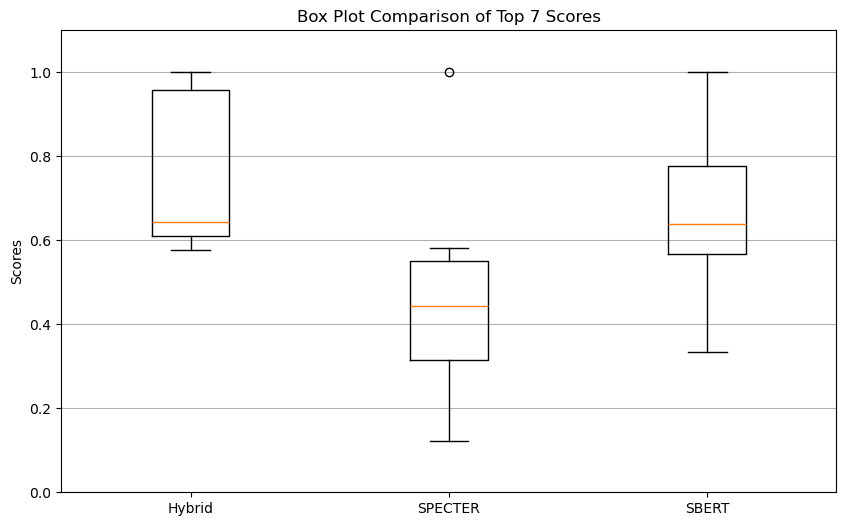

In [6]:
def plot_box_scores(hybrid_results, search_results_specter, search_results_sbert):
    # Get top 7 results for each model
    top_hybrid = hybrid_results[:7]
    top_specter = search_results_specter[:7]
    top_sbert = search_results_sbert[:7]

    # Extract scores
    hybrid_scores = [paper['score'] for paper in top_hybrid]
    specter_scores = [hit['score'] for hit in top_specter]
    sbert_scores = [hit['score'] for hit in top_sbert]

    # Combine scores into a single data structure for boxplot
    data = [hybrid_scores, specter_scores, sbert_scores]
    
    # Create box plot
    plt.figure(figsize=(10, 6))
    plt.boxplot(data, labels=['Hybrid', 'SPECTER', 'SBERT'])
    plt.ylabel('Scores')
    plt.title('Box Plot Comparison of Top 7 Scores')
    plt.grid(axis='y')
    plt.ylim(0, max(max(hybrid_scores), max(specter_scores), max(sbert_scores)) + 0.1)  # Adjusting Y-axis
    plt.show()

# Plot the box plot for the top scores
plot_box_scores(all_results, search_results_specter, search_results_sbert)


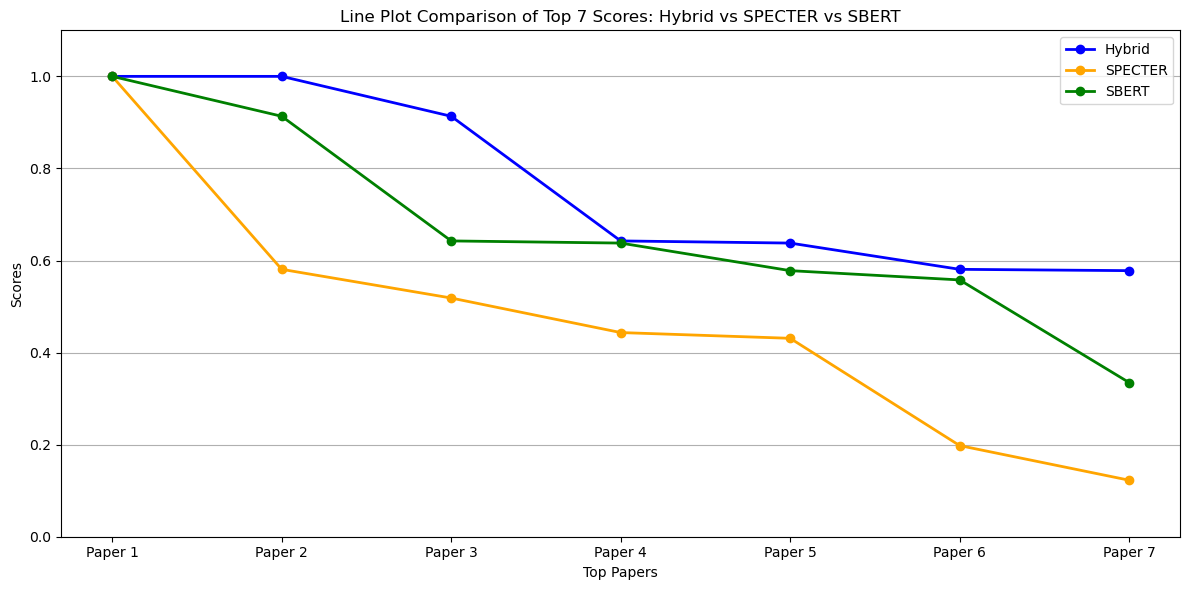

In [7]:
def plot_line_scores(hybrid_results, search_results_specter, search_results_sbert):
    # Get top 7 results for each model
    top_hybrid = hybrid_results[:7]
    top_specter = search_results_specter[:7]
    top_sbert = search_results_sbert[:7]

    # Extract scores
    hybrid_scores = [paper['score'] for paper in top_hybrid]
    specter_scores = [hit['score'] for hit in top_specter]
    sbert_scores = [hit['score'] for hit in top_sbert]

    # Create line plot
    plt.figure(figsize=(12, 6))
    plt.plot(hybrid_scores, marker='o', label='Hybrid', color='blue', linewidth=2)
    plt.plot(specter_scores, marker='o', label='SPECTER', color='orange', linewidth=2)
    plt.plot(sbert_scores, marker='o', label='SBERT', color='green', linewidth=2)

    # Labeling the plot
    plt.xlabel('Top Papers')
    plt.ylabel('Scores')
    plt.title('Line Plot Comparison of Top 7 Scores: Hybrid vs SPECTER vs SBERT')
    plt.xticks(range(7), [f'Paper {i+1}' for i in range(7)])  # X-axis labels
    plt.ylim(0, max(max(hybrid_scores), max(specter_scores), max(sbert_scores)) + 0.1)  # Adjusting Y-axis
    plt.legend()
    plt.grid(axis='y')  # Adding grid for better readability
    plt.tight_layout()  # Adjust layout to avoid clipping
    plt.show()

# Plot the line plot for the top scores
plot_line_scores(all_results, search_results_specter, search_results_sbert)


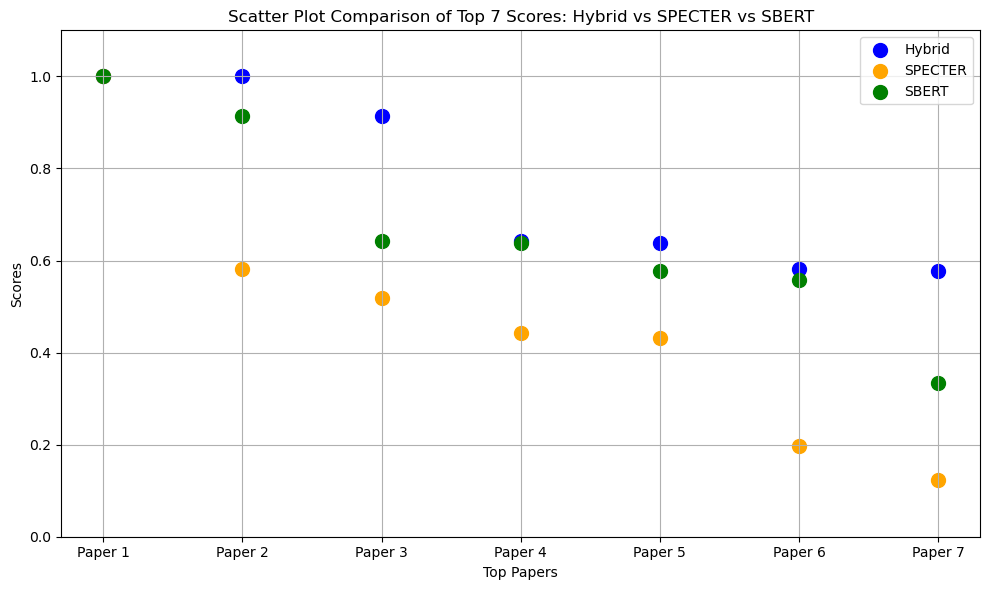

In [8]:
def plot_scatter_scores(hybrid_results, search_results_specter, search_results_sbert):
    # Get top 7 results for each model
    top_hybrid = hybrid_results[:7]
    top_specter = search_results_specter[:7]
    top_sbert = search_results_sbert[:7]

    # Extract scores
    hybrid_scores = [paper['score'] for paper in top_hybrid]
    specter_scores = [hit['score'] for hit in top_specter]
    sbert_scores = [hit['score'] for hit in top_sbert]

    # Create scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(range(1,8), hybrid_scores, color='blue', label='Hybrid', s=100)
    plt.scatter(range(1, 8), specter_scores, color='orange', label='SPECTER', s=100)
    plt.scatter(range(1, 8), sbert_scores, color='green', label='SBERT', s=100)

    # Labeling the plot
    plt.xlabel('Top Papers')
    plt.ylabel('Scores')
    plt.title('Scatter Plot Comparison of Top 7 Scores: Hybrid vs SPECTER vs SBERT')
    plt.xticks(range(1, 8), [f'Paper {i+1}' for i in range(7)])  # X-axis labels
    plt.ylim(0, max(max(hybrid_scores), max(specter_scores), max(sbert_scores)) + 0.1)  # Adjusting Y-axis
    plt.legend()
    plt.grid(True)
    plt.tight_layout()  # Adjust layout to avoid clipping
    plt.show()

# Plot the scatter plot for the top scores
plot_scatter_scores(all_results, search_results_specter, search_results_sbert)


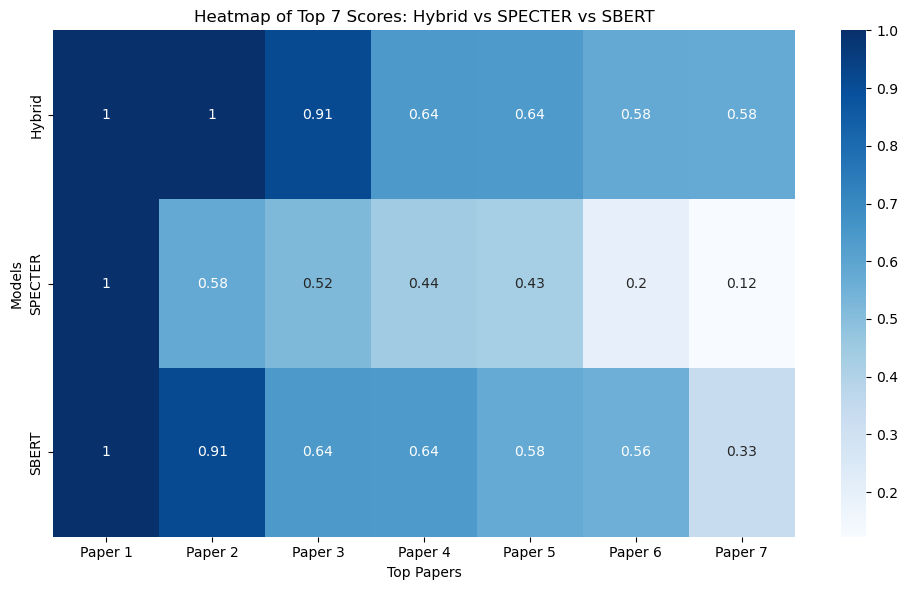

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_heatmap_scores(hybrid_results, search_results_specter, search_results_sbert):
    # Get top 7 results for each model
    top_hybrid = hybrid_results[:7]
    top_specter = search_results_specter[:7]
    top_sbert = search_results_sbert[:7]

    # Extract scores
    hybrid_scores = [paper['score'] for paper in top_hybrid]
    specter_scores = [hit['score'] for hit in top_specter]
    sbert_scores = [hit['score'] for hit in top_sbert]

    # Prepare data for heatmap
    scores_matrix = np.array([hybrid_scores, specter_scores, sbert_scores])

    # Create a heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(scores_matrix, annot=True, cmap="Blues", xticklabels=[f'Paper {i+1}' for i in range(7)], yticklabels=['Hybrid', 'SPECTER', 'SBERT'], cbar=True)

    # Title and labels
    plt.title('Heatmap of Top 7 Scores: Hybrid vs SPECTER vs SBERT')
    plt.xlabel('Top Papers')
    plt.ylabel('Models')

    # Show the plot
    plt.tight_layout()
    plt.show()

# Plot the heatmap for the top scores
plot_heatmap_scores(all_results, search_results_specter, search_results_sbert)


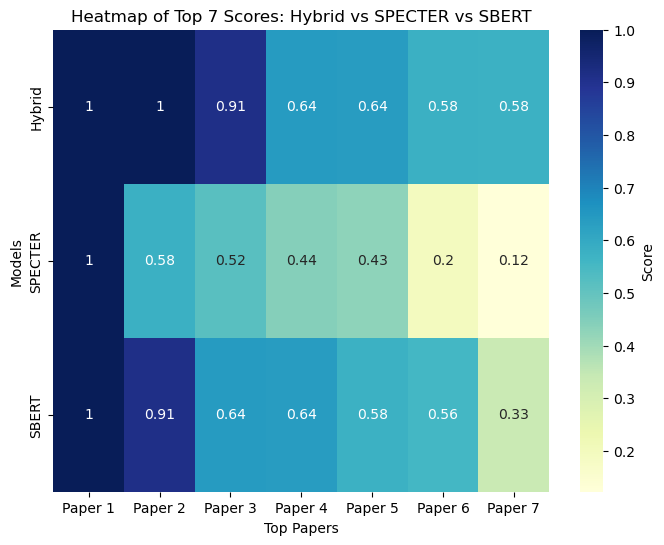

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_heatmap_scores(hybrid_results, search_results_specter, search_results_sbert):
    # Get top 7 results for each model
    top_hybrid = hybrid_results[:7]
    top_specter = search_results_specter[:7]
    top_sbert = search_results_sbert[:7]

    # Extract scores
    hybrid_scores = [paper['score'] for paper in top_hybrid]
    specter_scores = [hit['score'] for hit in top_specter]
    sbert_scores = [hit['score'] for hit in top_sbert]

    # Combine into a matrix for heatmap (each row represents a model, each column represents a paper)
    data = np.array([hybrid_scores, specter_scores, sbert_scores])

    # Create heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(data, annot=True, cmap="YlGnBu", xticklabels=[f'Paper {i+1}' for i in range(7)], yticklabels=['Hybrid', 'SPECTER', 'SBERT'], cbar_kws={'label': 'Score'})

    # Labeling the plot
    plt.title('Heatmap of Top 7 Scores: Hybrid vs SPECTER vs SBERT')
    plt.xlabel('Top Papers')
    plt.ylabel('Models')
    plt.show()

# Generate the heatmap
plot_heatmap_scores(all_results, search_results_specter, search_results_sbert)


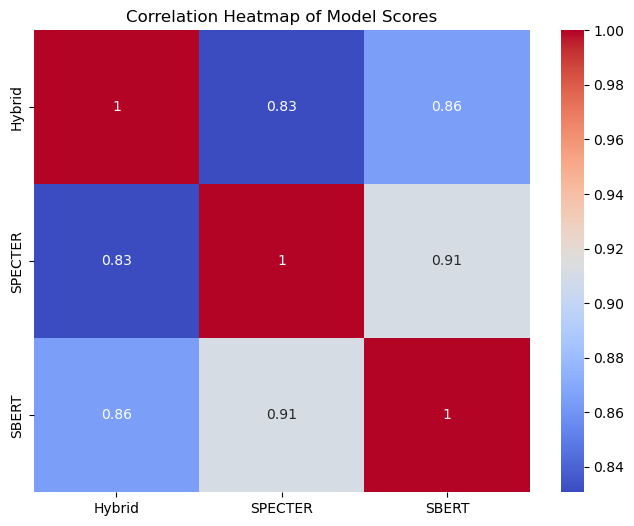

In [11]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


# correlation matrix 
def plot_score_correlation(hybrid_scores, specter_scores, sbert_scores):
    # Create a matrix of scores from each model
    score_matrix = np.array([hybrid_scores, specter_scores, sbert_scores])
    correlation_matrix = np.corrcoef(score_matrix)

    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', 
                xticklabels=['Hybrid', 'SPECTER', 'SBERT'], yticklabels=['Hybrid', 'SPECTER', 'SBERT'])
    plt.title('Correlation Heatmap of Model Scores')
    plt.show()

# Extract scores from top 7 results
hybrid_scores = [paper['score'] for paper in all_results[:7]]
specter_scores = [hit['score'] for hit in search_results_specter[:7]]
sbert_scores = [hit['score'] for hit in search_results_sbert[:7]]

# Plot the heatmap
plot_score_correlation(hybrid_scores, specter_scores, sbert_scores)

